# Antispam

Обучение проходило на нейронной сети (многослойный персептрон) с 2 скрытыми слоями (архитектура - 3823-200-100-1).

Предварительно слои предобучивались с помощью RBM.
Для нейронной сети я использовала свой код - DBN.py

Берутся все слова, видимые пользователю, проводится нормализация с помощью pymorphy. Собираю бинарный мешок слов и пускаю в нейронную сеть.

In [3]:
from __future__ import division

import json
import base64
import random
from collections import Counter
import os.path
import imp
import gzip

import sys
import csv
import gc

import numpy as np
import pandas as pd
import sklearn.preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import f1_score


%matplotlib notebook
import matplotlib.pyplot as plt


import logging
reload(logging)
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO, datefmt='%H:%M:%S')

In [4]:
from DBN import *

### Утилиты

#### Декораторы

In [5]:
def convert2unicode(f):
    def tmp(text):
        if not isinstance(text, unicode): text = text.decode('utf8')
        return f(text)
    return tmp

def convert2lower(f):
    def tmp(text):        
        return f(text.lower())
    return tmp

#P.S. Декораторы могут усложнять отладку, так что от них вполне можно отказаться и воспользоваться copy-paste

### Извлечение текста из html

#### Извлечение текста при помощи встроенных модулей

In [6]:
from HTMLParser import HTMLParser
import re

###Извлечение текста из title можно вписать сюда

class AntiPornHTMLParser(HTMLParser):
    def __init__(self):
        HTMLParser.__init__(self)
        self.__text = []
        self._title = ""
        self._in_title = False

    def handle_data(self, data):
        text = data.strip()
        if len(text) > 0:
            text = re.sub('[ \t\r\n]+', ' ', text)
            self.__text.append(text + ' ')

    def handle_starttag(self, tag, attrs):
        if tag == 'p':
            self.__text.append('\n\n')
        elif tag == 'br':
            self.__text.append('\n')
        elif tag == 'title':
            self._in_title = True

    def handle_startendtag(self, tag, attrs):
        if tag == 'br':
            self.__text.append('\n\n')

    def text(self):
        return ''.join(self.__text).strip()

@convert2unicode
def html2text_parser(text):
    parser = AntiPornHTMLParser()
    parser.feed(text)
    return parser.text()

#### Извлечение текста при помощи дополнительных библиотек

In [7]:
def html2text_bs(raw_html):
    from bs4 import BeautifulSoup
    """
    Тут производится извлечения из html текста
    """
    soup = BeautifulSoup(raw_html, "html.parser")
    [s.extract() for s in soup(['script', 'style'])]
    return soup.get_text()

def html2text_bs_visible(raw_html):
    from bs4 import BeautifulSoup
    """
    Тут производится извлечения из html текста, который видим пользователю
    """
    soup = BeautifulSoup(raw_html, "html.parser")    
    [s.extract() for s in soup(['style', 'script', '[document]', 'head', 'title'])]
    return soup.get_text()

def html2text_boilerpipe(raw_html):
    import boilerpipe
    """
    еще одна библиотека очень хорошо извлекающая именно видимый пользователю текст,
    но она завязана на java
    """
    pass

#### Выбираем какой метод для конвертации html в текст будет основным

In [8]:
#html2text = html2text_bs
#html2text = html2text_parser
html2text = html2text_bs_visible

#### Методы для токенизации текста

In [9]:
@convert2lower
@convert2unicode
def easy_tokenizer(text):
    word = unicode()
    for symbol in text:
        if symbol.isalnum(): word += symbol
        elif word:
            yield word
            word = unicode()
    if word: yield word

PYMORPHY_CACHE = {}
MORPH = None
#hint, чтобы установка pymorphy2 не была бы обязательной
def get_lemmatizer():
    import pymorphy2
    global MORPH
    if MORPH is None: MORPH = pymorphy2.MorphAnalyzer()
    return MORPH

@convert2lower
@convert2unicode
def pymorphy_tokenizer(text):
    global PYMORPHY_CACHE
    for word in easy_tokenizer(text):
        word_hash = hash(word)
        if word_hash not in PYMORPHY_CACHE:
            PYMORPHY_CACHE[word_hash] = get_lemmatizer().parse(word)[0].normal_form            
        yield PYMORPHY_CACHE[word_hash]

#### Основная функция, которая вызывается для преобразования html в список слов

In [10]:
def html2word(raw_html, to_text=html2text, tokenizer=pymorphy_tokenizer):
    return tokenizer(to_text(raw_html).lower())

#### Рассчет финальных метрик

In [11]:
def safe_divide(a, b):
    if a == 0: return 0.0
    elif b == 0: return 0.0
    else: return a/b

def calculate_metrics(predictions, threshold):    
    """
    Функция подсчета метрик
    Параметры
    predictions - ранки по документам
    threshold  - порог для метрик
    """
    true_positive = 0
    false_positive = 0
    true_negative = 0
    false_negative = 0
    for (url_id, mark, url, prediction) in predictions:        
        mark_predict = prediction > threshold

        if mark_predict:                     
            if mark_predict == mark: true_positive += 1
            else: false_positive += 1                    
        else:                     
            if  mark_predict == mark: true_negative += 1
            else: false_negative += 1

    class_prec  = safe_divide(true_positive, true_positive + false_positive)
    class_recall = safe_divide(true_positive, true_positive + false_negative)
        
    class_F1 = safe_divide(2 * class_prec * class_recall, class_prec + class_recall)
    
    
    not_class_prec = safe_divide(true_negative, true_negative + false_negative)
    not_class_recall = safe_divide(true_negative, true_negative + false_positive)
    
    not_class_F1 = safe_divide(2 * not_class_prec * not_class_recall, not_class_prec + not_class_recall)
    
    return ( (class_prec, class_recall, class_F1), (not_class_prec, not_class_recall, not_class_F1) )

def arange(start, stop, step):
    cur_value = start
    while True:
        if cur_value > stop: break
        yield cur_value
        cur_value += step

def plot_results(docs, min_threshold=-1, max_threshold=1, step=0.1, trace=False):
    x = []
    y_p = []
    y_n = []
    docs_predictions = classifier.predict_all(docs)
    for threshold in arange(min_threshold, max_threshold, step):
        r = calculate_metrics(docs_predictions, threshold)
        x.append(threshold)
        y_p.append(r[0])
        y_n.append(r[1])        
        if trace: 
            print 'threshold %s' % threshold
            print '\tclass_prec %s, class_recall %s, class_F1 %s' % r[0]
            print '\tnot_class_prec %s, not_class_recall %s, not_class_F1 %s' % r[1]
            print '\t\tMacroF1Mesure %s' % ((r[0][2] + r[1][2])/2)
    plot_stats(x, y_p, "Class Result")
    plot_stats(x, y_n, "Not class Result")    


def plot_stats(x, y, title):
    plt.figure(figsize=(10, 5))

    prec, = plt.plot( x, 
                     [k[0] for k in y], "r", label='Precision', 
                     linewidth=1)
    accur, = plt.plot( x, 
                      [k[1] for k in y], "b", label='Recall',
                      linewidth=1)
    f1, =    plt.plot( x, 
                      [k[2] for k in y], "g", label='F1',
                      linewidth=1)
    plt.grid(True)
    plt.legend(handles=[prec, accur, f1])
    plt.title(title)
    plt.show()

In [12]:
def file2docs_txt(input_file_name, reparse=False):    
    result = []
    
    if os.path.exists(input_file_name + ".json") and not reparse:
        logging.info("File %s.json already exists - load it" % input_file_name)
        result = json.load(open(input_file_name + ".json", 'rb'))
    else:                                
        with gzip.open(input_file_name) if input_file_name.endswith('gz') else open(input_file_name)  as input_file:
            for i, line in enumerate(input_file):                
                parts = line.strip().split()

                url_id = int(parts[0])                
                mark = bool(int(parts[1]))
                url = parts[2]

                pageInb64 = parts[3]                
                html_data = base64.b64decode(pageInb64)                
                words = list(html2word(html_data))

                result.append( (url_id, mark, url, words))  

                if i % 100 == 0: logging.info("Complete %04d" % i)
        logging.info("Complete %04d" % i)
        logging.info("Create json dump %s" % (input_file_name + ".json"))
        json.dump(result, open(input_file_name + ".json", 'wb'))
    return result


def file2docs_csv(input_file_name, reparse=False):    
    result = []
    
    if os.path.exists(input_file_name + ".json") and not reparse:
        logging.info("File %s.json already exists - load it" % input_file_name)
        result = json.load(open(input_file_name + ".json", 'rb'))
    else:                                
        with gzip.open(input_file_name) if input_file_name.endswith('gz') else open(input_file_name)  as input_file:            
            headers = input_file.readline()
            try:
                for i, line in enumerate(input_file):

                    parts = line.strip().split('\t')
                    url_id = int(parts[0])                                        
                    mark = bool(int(parts[1]))                    
                    url = parts[2]
                    pageInb64 = parts[3]
                    html_data = base64.b64decode(pageInb64)                
                    words = list(html2word(html_data))

                    result.append( (url_id, mark, url, words))  
                    if i % 100 == 0: logging.info("Complete %04d" % i)
            except:
                print i, parts                
                raise

                    
        logging.info("Complete %04d" % i)
        logging.info("Create json dump %s" % (input_file_name + ".json"))
        json.dump(result, open(input_file_name + ".json", 'wb'))
    return result

** Обрабатываем входной файл **
<br>
Формат - поля разделенные табуляциями
<br>
0 - идентификатор документа
<br>
1 - метка класса 0 - не спам, 1 - спам
<br>
2 - урл документа
<br>
3 - документ в кодировке base64

Выходной формат - массив кортежей вида
(doc_id, is_spam, url, words)

In [12]:
TRAIN_DATA_FILE  = './kaggle/kaggle_train_data_tab.csv.gz'

REPARSE = False

train_docs = file2docs_csv(TRAIN_DATA_FILE, reparse=REPARSE)

23:42:08 INFO:File ./kaggle_train_data_tab.csv.gz.json already exists - load it


In [13]:
len(train_docs)

7044

In [15]:
print train_docs[10][0]
print train_docs[10][1]
print train_docs[10][2]
# print train_docs[10][3]
# print type(train_docs[0][3])
f = open('debug', 'w')
f.write(str(train_docs[0][3]))
f.close()

for i in train_docs[10][3]:
    print i

-9196615556004000760
True
http://gvhoqnwj.blogonline.ru/869.html
интернет
фото
видео
файл
работа
реферат
magna
пример
покупка
авто
gvhoqnwj
в
блог
теперь
модно
постить
тут
порно
бесплатнщий
2008
08
05
07
53
00
порно
бесплатнщий
порно
бесплатнщий
порно
бесплатнщий
скачать
порно
фильм
алин
кабаев
эротический
прикол
спорт
болельщик
секс
и
pissing
школьница
порно
девственность
канцелярия
для
девочка
инцест
сайт
18
летний
голый
девочка
фот
порно
фото
нимфеток
и
цёлка
в
чулок
делать
секс
палец
бсплатный
скачать
медия
порно
фильм
лада
денс
голый
фото
фото
волосатый
пизда
бесплатно
девка
и
секс
порно
рассказ
с
ребёнок
самый
хороший
народный
средство
по
поднятие
процент
подвижный
спермотозоид
в
сперма
мужчина
скачать
фото
порно
старуха
самый
красивый
голый
за
весь
история
футбол
скачать
порно
фильм
инцест
порно
фото
один
секс
актриса
порно
фильм
зоофил
порно
галерея
я
трахать
в
писька
шлюха
масква
порно
видео
бондаж
скачать
виа
гра
эротика
возможность
как
данность
то
чтопросмотр
порнокартинка
с

In [16]:
print train_docs[10][0]
print train_docs[10][1]
print train_docs[10][2]
# print train_docs[10][3]
# print type(train_docs[0][3])
f = open('debug', 'w')
f.write(str(train_docs[0][3]))
f.close()

for i in train_docs[10][3]:
    print i

-9196615556004000760
True
http://gvhoqnwj.blogonline.ru/869.html
интернет
фото
видео
файл
работа
реферат
magna
пример
покупка
авто
gvhoqnwj
в
блог
теперь
модно
постить
тут
порно
бесплатнщий
2008
08
05
07
53
00
порно
бесплатнщий
порно
бесплатнщий
порно
бесплатнщий
скачать
порно
фильм
алин
кабаев
эротический
прикол
спорт
болельщик
секс
и
pissing
школьница
порно
девственность
канцелярия
для
девочка
инцест
сайт
18
летний
голый
девочка
фот
порно
фото
нимфеток
и
цёлка
в
чулок
делать
секс
палец
бсплатный
скачать
медия
порно
фильм
лада
денс
голый
фото
фото
волосатый
пизда
бесплатно
девка
и
секс
порно
рассказ
с
ребёнок
самый
хороший
народный
средство
по
поднятие
процент
подвижный
спермотозоид
в
сперма
мужчина
скачать
фото
порно
старуха
самый
красивый
голый
за
весь
история
футбол
скачать
порно
фильм
инцест
порно
фото
один
секс
актриса
порно
фильм
зоофил
порно
галерея
я
трахать
в
писька
шлюха
масква
порно
видео
бондаж
скачать
виа
гра
эротика
возможность
как
данность
то
чтопросмотр
порнокартинка
с

In [18]:
import zlib
def calc_stats(words):
    #TODO Сюда вписать код для рассчета остальных 
    average_word_len = 0
    cnt_words = 0
    for_zip = ""
    for word in words:
        average_word_len += len(word)
        cnt_words += 1
        for_zip += word.encode("utf-8") + ' '
    
    #print for_zip
    inp = len(for_zip[:-1])
    outp = len(zlib.compress(for_zip[:-1], 9))
    compress_coef = float(outp)/inp
    if compress_coef > 1 :
        print for_zip[:-1], inp, outp
    return [len(words), float(average_word_len) / cnt_words, 0, 0, float(outp)/inp]

In [119]:
df = pd.DataFrame(columns=['doc_id', 'spam', 'url', 'num_words', 'avg_word_len', 'num_words_title', 'num_words_a', 'compress_coef'])

for doc in train_docs:
    doc_id, is_spam, url, words = doc
    df.loc[len(df)] = [doc_id, is_spam, url] + calc_stats(words)

<IPython.core.display.Javascript object>


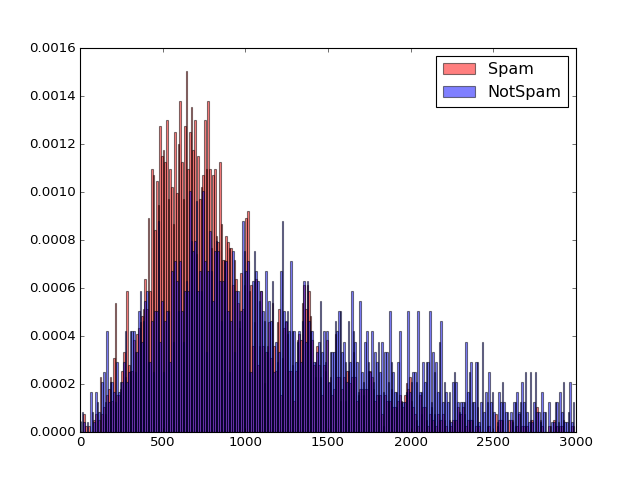

In [120]:
column = 'num_words'
plt.figure()
plt.hist(df[df.spam][column].reset_index(drop=True), color='red', alpha=0.5, label="Spam", bins=range(0,3000,10), normed=1)
plt.hist(df[df.spam == False][column].reset_index(drop=True), color='blue', alpha=0.5, label="NotSpam", bins=range(0,3000,10), normed=1)
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


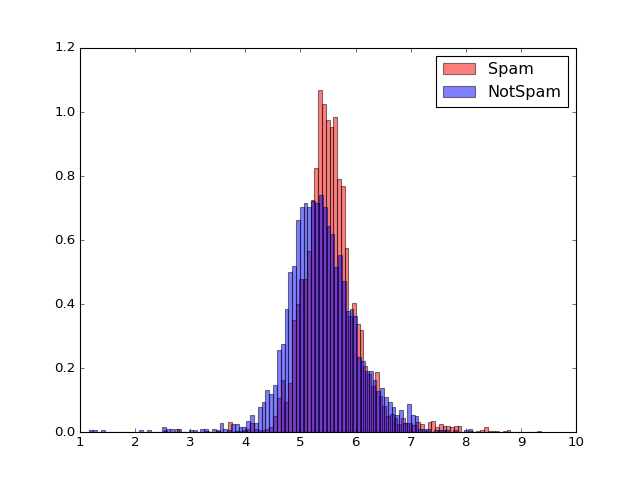

In [121]:
column = 'avg_word_len'
plt.figure()
plt.hist(df[df.spam][column].reset_index(drop=True), color='red', alpha=0.5, label="Spam", bins=100, normed=1)
plt.hist(df[df.spam == False][column].reset_index(drop=True), color='blue', alpha=0.5, label="NotSpam", bins=100, normed=1)
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


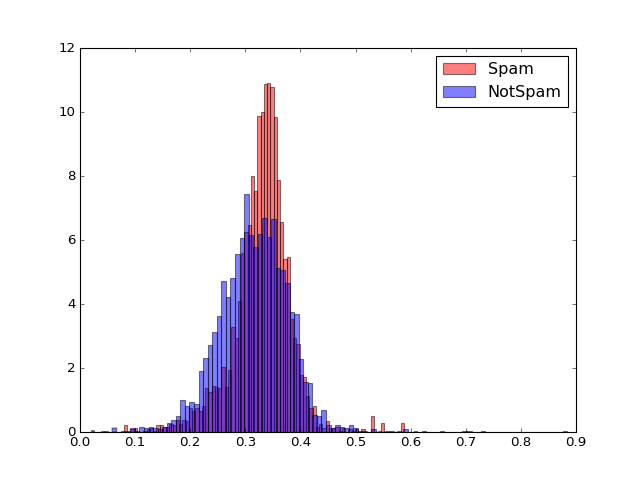

In [122]:
column = 'compress_coef'
plt.figure()
plt.hist(df[df.spam][column].reset_index(drop=True), color='red', alpha=0.5, label="Spam", bins=100, normed=1)
plt.hist(df[df.spam == False][column].reset_index(drop=True), color='blue', alpha=0.5, label="NotSpam", bins=100, normed=1)
plt.legend()
plt.show()

** Классификатор: **
Нужно реализовать

In [70]:
import math

class Classifier:
    
    def __init__(self):
        pass
    
    def predict_rand(self, words):        
        random.seed(hash(len(words))) #чтобы для заданного документа результат был бы постоянен
        return random.random()
    
    def is_class(self, words, threshold):
        return self.predict(words) > threshold

    def predict(self, doc):        
        average_word_len = 0
        cnt_words = 0
        for word in doc[3]:
#             print "sf"
            average_word_len += len(word)
            cnt_words += 1
            
        return float(average_word_len) / cnt_words       
        
    
    def predict_all(self, docs):
        res = []
        for doc in docs:            
            prediction = self.predict(doc)
            (url_id, mark, url, words) = doc
            res.append( (url_id, mark, url, prediction) )
        return res
    
    def train(self, docs):                
        for i, (url_id, mark, url, words) in enumerate(docs):                            
            #TODO вставить код обучения
            if i % 1000 == 0: logging.info("Complete %04d docs" % i)
        logging.info("Complete %04d docs" % i)

In [71]:
classifier = Classifier()
classifier.train(train_docs)

20:33:45 INFO:Complete 0000 docs
20:33:45 INFO:Complete 1000 docs
20:33:45 INFO:Complete 2000 docs
20:33:45 INFO:Complete 3000 docs
20:33:45 INFO:Complete 4000 docs
20:33:45 INFO:Complete 5000 docs
20:33:45 INFO:Complete 6000 docs
20:33:45 INFO:Complete 7000 docs
20:33:45 INFO:Complete 7043 docs


In [72]:
#Посмотреть, что предсказывается для текста из одного слова 'порно'
word = u'порно'
classifier.predict((0, 0, 'http://ololo', [word]))
#print len(word)

5.0

** Рисуем графики **

threshold 0
	class_prec 0.583333333333, class_recall 1.0, class_F1 0.736842105263
	not_class_prec 0.0, not_class_recall 0.0, not_class_F1 0.0
		MacroF1Mesure 0.368421052632
threshold 0.05
	class_prec 0.583333333333, class_recall 1.0, class_F1 0.736842105263
	not_class_prec 0.0, not_class_recall 0.0, not_class_F1 0.0
		MacroF1Mesure 0.368421052632
threshold 0.1
	class_prec 0.583333333333, class_recall 1.0, class_F1 0.736842105263
	not_class_prec 0.0, not_class_recall 0.0, not_class_F1 0.0
		MacroF1Mesure 0.368421052632
threshold 0.15
	class_prec 0.583333333333, class_recall 1.0, class_F1 0.736842105263
	not_class_prec 0.0, not_class_recall 0.0, not_class_F1 0.0
		MacroF1Mesure 0.368421052632
threshold 0.2
	class_prec 0.583333333333, class_recall 1.0, class_F1 0.736842105263
	not_class_prec 0.0, not_class_recall 0.0, not_class_F1 0.0
		MacroF1Mesure 0.368421052632
threshold 0.25
	class_prec 0.583333333333, class_recall 1.0, class_F1 0.736842105263
	not_class_prec 0.0, not_class_recall 0.

<IPython.core.display.Javascript object>


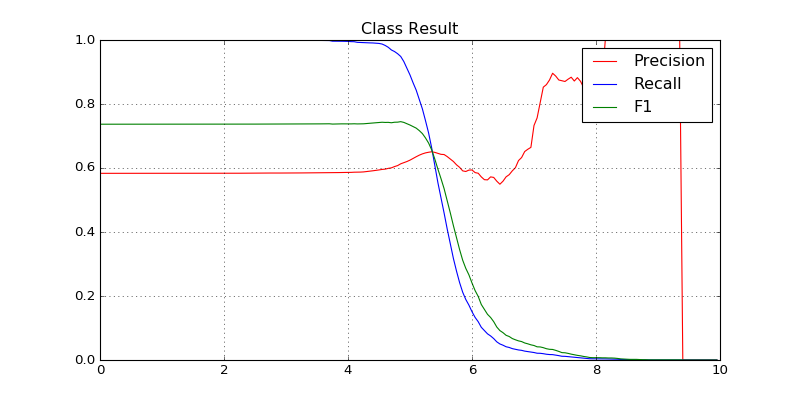

<IPython.core.display.Javascript object>


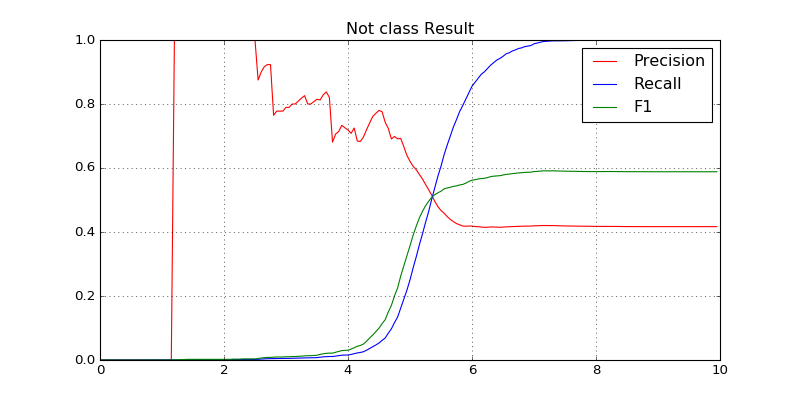

In [73]:
plot_results(train_docs, min_threshold=0, max_threshold=10, step=0.05, trace=1)

In [74]:
#Для тех у кого меньше 4GB RAM
# del train_docs
# gc.collect()

TEST_DATA_FILE  = 'kaggle/kaggle_test_data_tab.csv.gz'

test_docs = file2docs_csv(TEST_DATA_FILE, reparse=REPARSE)

threshold = 5.25

with open('my_submission.csv' , 'wb') as fout:
    writer = csv.writer(fout)
    writer.writerow(['Id','Prediction'])
    for item in classifier.predict_all(test_docs):
        prediction =  1 if item[3] > threshold else 0
        writer.writerow([item[0], prediction])
    
#Нужно для принудительной очистки памяти (всем у кого 8GB и особенно меньше)
#По хорошему в случае малого кол-ва памяти надо вычислять предсказание построчно и не грузить в память все данные
del test_docs
gc.collect()

20:36:04 INFO:Complete 0000
20:36:06 INFO:Complete 0100
20:36:08 INFO:Complete 0200
20:36:10 INFO:Complete 0300
20:36:11 INFO:Complete 0400
20:36:14 INFO:Complete 0500
20:36:16 INFO:Complete 0600
20:36:17 INFO:Complete 0700
20:36:19 INFO:Complete 0800
20:36:22 INFO:Complete 0900
20:36:27 INFO:Complete 1000
20:36:32 INFO:Complete 1100
20:36:34 INFO:Complete 1200
20:36:36 INFO:Complete 1300
20:36:38 INFO:Complete 1400
20:36:40 INFO:Complete 1500
20:36:42 INFO:Complete 1600
20:36:44 INFO:Complete 1700
20:36:45 INFO:Complete 1800
20:36:47 INFO:Complete 1900
20:36:49 INFO:Complete 2000
20:36:51 INFO:Complete 2100
20:36:54 INFO:Complete 2200
20:36:56 INFO:Complete 2300
20:36:58 INFO:Complete 2400
20:37:00 INFO:Complete 2500
20:37:02 INFO:Complete 2600
20:37:04 INFO:Complete 2700
20:37:05 INFO:Complete 2800
20:37:07 INFO:Complete 2900
20:37:08 INFO:Complete 3000
20:37:10 INFO:Complete 3100
20:37:12 INFO:Complete 3200
20:37:14 INFO:Complete 3300
20:37:16 INFO:Complete 3400
20:37:17 INFO:Comple

41675

## Попробуем обучить DBN на бинарном мешке слов

In [19]:
docs_rows = []
index = []

for doc in train_docs:
    index.append(doc[1])
    docs_rows.append(" ".join(doc[3]))

In [20]:
print len(index)
print len(docs_rows)
print docs_rows[1], index[1]

7044
7044
главный форум и обсуждение блог творчество открытка реферат социальный сеть classifieds one ru лицо друг 55 ru chats ru wd ru web design магазин ec ru uzru мир общение общение знакомство форум обсуждение социальный сеть хуш келибсизый хуш омадед хoş gəlmisiniz жақсылық шақырғанғ кел добро пожаловать приглашать к общение на наш сайт вы мочь создавать свой тема и комментарий закачивать файл фото создавать группа общаться и знакомиться с новый человек а также ещё множество другой полезный вещий наш rss feed бизнес и финас новость и политика общение и знакомство прочее чат разместить в категория от admin комментарий отключить 16 02 2011 чат новость и политика last message5 час ов 35 минута ы ago11 гость она в сеть gvhg52 g гость 2436 salam bratsi гость 613 гость 613 гость 613 гость 613 гость 613 гость 613 гость 613 гость 613 гость 613 гость 958 краснодар есть гость 3311 весь сало a3amat сало inkubator201 сало привет гость 3144 из питер есть толстой девушка лялечка эй ребятки ляле

In [21]:
count_vectorizer = CountVectorizer(binary = True, analyzer="word", min_df = 0.02, max_df = 0.9)
counts_words = count_vectorizer.fit_transform(docs_rows)

In [22]:
print counts_words.shape
print index[:10]
print train_docs[5][1]
counts_words = counts_words.toarray()

(7044, 3823)
[False, False, False, False, True, True, True, True, True, False]
True


In [23]:
labels = [int(i) for i in index]
labels = np.asarray(labels).reshape(-1, 1)
print labels[:10]

[[0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]]


In [24]:
print counts_words[0].sum()

477


In [26]:
from sklearn.cross_validation import KFold

k_fold = KFold(n=counts_words.shape[0], n_folds=10, shuffle=True)
scores = []
for train_indices, test_indices in k_fold:
    
    inp = InputLayer(counts_words.shape[1])
    l1 = Layer(num_nodes=200, prev_num_nodes = counts_words.shape[1], bias=True, activate="sigmoid")
    l2 = Layer(num_nodes=100, prev_num_nodes = 200, bias=True, activate="sigmoid")
#     l3 = Layer(num_nodes=2000, prev_num_nodes = 500, bias=True, activate="sigmoid")
    out = OutputLayer(num_nodes=1, prev_num_nodes = 100, bias=True, activate='sigmoid')
    
    DBN_model = DBN(layers=[inp, l1,l2, out])
    DBN_model.fit(counts_words[train_indices],
                    labels[train_indices], 30, 4000, \
                    learning_ratio = 0.1, loss_function = "MSE", RBM_initialize = True)
    break

True
True
True
True
____________________________________________________________
Train weights betweeen layer 0 and layer 1
Training epoch: 0
MSE distance between input and reconstruction: 0.395012642776
Training epoch: 100
MSE distance between input and reconstruction: 0.102197227308
Training epoch: 200
MSE distance between input and reconstruction: 0.0854390095039
Training epoch: 300
MSE distance between input and reconstruction: 0.0805737204639
Training epoch: 400
MSE distance between input and reconstruction: 0.0819600662656
Training epoch: 500
MSE distance between input and reconstruction: 0.0856569884035
Training epoch: 600
MSE distance between input and reconstruction: 0.094541808353
Training epoch: 700
MSE distance between input and reconstruction: 0.0887086929985
Training epoch: 800
MSE distance between input and reconstruction: 0.0970529252768
Training epoch: 900
MSE distance between input and reconstruction: 0.0795448600575
Training epoch: 1000
MSE distance between input and

In [27]:
model_res = DBN_model.predict(counts_words[test_indices])

In [28]:
print model_res

[[  9.99808399e-01]
 [  9.99489009e-01]
 [  3.05777839e-03]
 [  9.99932129e-01]
 [  9.99856986e-01]
 [  9.99999695e-01]
 [  9.21012773e-01]
 [  9.99981858e-01]
 [  2.37028992e-02]
 [  7.77013606e-04]
 [  9.97494109e-01]
 [  1.94840887e-04]
 [  9.65527418e-01]
 [  1.10579237e-02]
 [  6.71071167e-03]
 [  8.16623656e-25]
 [  9.99966622e-01]
 [  9.30708299e-05]
 [  1.51042006e-13]
 [  9.99998461e-01]
 [  1.48702837e-03]
 [  2.24794824e-02]
 [  9.11598053e-01]
 [  9.92794209e-01]
 [  8.55669421e-01]
 [  9.97758242e-01]
 [  9.35168827e-01]
 [  1.16503642e-01]
 [  9.99957237e-01]
 [  9.79497842e-01]
 [  9.80825908e-01]
 [  9.99992727e-01]
 [  1.05325347e-85]
 [  5.21232789e-03]
 [  1.09552518e-02]
 [  6.90053588e-02]
 [  9.99437440e-01]
 [  6.48952693e-04]
 [  2.34924639e-83]
 [  9.99993721e-01]
 [  9.99999754e-01]
 [  9.99549650e-01]
 [  9.99999968e-01]
 [  9.99985840e-01]
 [  9.96491671e-01]
 [  9.99753843e-01]
 [  9.85726771e-09]
 [  9.99999900e-01]
 [  1.13853120e-01]
 [  3.96678818e-04]


In [29]:
roc_auc = roc_auc_score(labels[test_indices], model_res)
print roc_auc

0.97252774434


In [30]:
binary_res = [1 if r[0] > 0.5 else 0 for r in model_res]
print binary_res

[1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 

In [31]:
print f1_score(labels[test_indices], binary_res)  

0.949874686717


### Пробуем 3 слоя - ничего не вышло :(

In [43]:
from sklearn.cross_validation import KFold
#запихивать параметры rbm в dbn!
k_fold = KFold(n=counts_words.shape[0], n_folds=10, shuffle=True)
scores = []
for train_indices, test_indices in k_fold:
    
    inp = InputLayer(counts_words.shape[1])
    l1 = Layer(num_nodes=1000, prev_num_nodes = counts_words.shape[1], bias=True, activate="sigmoid")
    l2 = Layer(num_nodes=500, prev_num_nodes = 1000, bias=True, activate="sigmoid")
    l3 = Layer(num_nodes=200, prev_num_nodes = 500, bias=True, activate="sigmoid")
    out = OutputLayer(num_nodes=1, prev_num_nodes = 200, bias=True, activate='sigmoid')
    
    DBN_model_3 = DBN(layers=[inp, l1,l2, l3, out])
    DBN_model_3.fit(counts_words[train_indices],
                    labels[train_indices], 30, 4000, \
                    learning_ratio = 0.1, loss_function = "MSE", RBM_initialize = True)
    
    break

True
True
True
True
True
____________________________________________________________
Train weights betweeen layer 0 and layer 1
Training epoch: 0
MSE distance between input and reconstruction: 0.245182666318
Training epoch: 100
MSE distance between input and reconstruction: 0.114290696661
Training epoch: 200
MSE distance between input and reconstruction: 0.0830848373877
Training epoch: 300
MSE distance between input and reconstruction: 0.0686895108553
Training epoch: 400
MSE distance between input and reconstruction: 0.0918127125294
Training epoch: 500
MSE distance between input and reconstruction: 0.0641468305868
Training epoch: 600
MSE distance between input and reconstruction: 0.0698840352254
Training epoch: 700
MSE distance between input and reconstruction: 0.0626732932252
Training epoch: 800
MSE distance between input and reconstruction: 0.0604411892929
Training epoch: 900
MSE distance between input and reconstruction: 0.0590461243352
Training epoch: 1000
MSE distance between inp

KeyboardInterrupt: 

## Пробуем подобрать параметры длы 2 слоев

In [50]:
print "3823 - 200 - 100 - 1", "learning_rate_RBM = 0.01"

from sklearn.cross_validation import KFold
#запихивать параметры rbm в dbn!
k_fold = KFold(n=counts_words.shape[0], n_folds=10, shuffle=True)
scores = []
for train_indices, test_indices in k_fold:
    print "__________________________________________________"
    inp = InputLayer(counts_words.shape[1])
    l1 = Layer(num_nodes=200, prev_num_nodes = counts_words.shape[1], bias=True, activate="sigmoid")
    l2 = Layer(num_nodes=100, prev_num_nodes = 200, bias=True, activate="sigmoid")
#     l3 = Layer(num_nodes=2000, prev_num_nodes = 500, bias=True, activate="sigmoid")
    out = OutputLayer(num_nodes=1, prev_num_nodes = 100, bias=True, activate='sigmoid')
    
    DBN_model = DBN(layers=[inp, l1,l2, out])
    DBN_model.fit(counts_words[train_indices],
                    labels[train_indices], 30, 4000, \
                    learning_ratio = 0.1, loss_function = "MSE", RBM_initialize = True)
    
    model_res = DBN_model.predict(counts_words[test_indices])
    binary_res = [1 if r[0] > 0.5 else 0 for r in model_res]
    print "F1 - SCORE: ", f1_score(labels[test_indices], binary_res)  
    

3823 - 200 - 100 - 1 learning_rate_RBM = 0.01
__________________________________________________
True
True
True
True
____________________________________________________________
Train weights betweeen layer 0 and layer 1
Training epoch: 0
MSE distance between input and reconstruction: 0.40093294969
Training epoch: 100
MSE distance between input and reconstruction: 0.113122329758
Training epoch: 200
MSE distance between input and reconstruction: 0.0811840613829
Training epoch: 300
MSE distance between input and reconstruction: 0.0901037579562
Training epoch: 400
MSE distance between input and reconstruction: 0.0833551312233
Training epoch: 500
MSE distance between input and reconstruction: 0.0714796407708
Training epoch: 600
MSE distance between input and reconstruction: 0.0821082919173
Training epoch: 700
MSE distance between input and reconstruction: 0.0918127125294
Training epoch: 800
MSE distance between input and reconstruction: 0.0709390530997
Training epoch: 900
MSE distance betw

In [56]:
F1_scores_1 = [] 
print "3823 - 500 - 200 - 1", "learning_rate_RBM = 0.03", "learning_rate_DBN = 0.05"

from sklearn.cross_validation import KFold
#запихивать параметры rbm в dbn!
k_fold = KFold(n=counts_words.shape[0], n_folds=3, shuffle=True)
scores = []
for train_indices, test_indices in k_fold:
    print "__________________________________________________"
    inp = InputLayer(counts_words.shape[1])
    l1 = Layer(num_nodes=500, prev_num_nodes = counts_words.shape[1], bias=True, activate="sigmoid")
    l2 = Layer(num_nodes=200, prev_num_nodes = 500, bias=True, activate="sigmoid")
#     l3 = Layer(num_nodes=2000, prev_num_nodes = 500, bias=True, activate="sigmoid")
    out = OutputLayer(num_nodes=1, prev_num_nodes = 200, bias=True, activate='sigmoid')
    
    DBN_model = DBN(layers=[inp, l1,l2, out])
    DBN_model.fit(counts_words[train_indices],
                    labels[train_indices], 30, 4000, \
                    learning_ratio = 0.05, loss_function = "MSE", RBM_initialize = True)
    
    model_res = DBN_model.predict(counts_words[test_indices])
    binary_res = [1 if r[0] > 0.5 else 0 for r in model_res]
    f1 = f1_score(labels[test_indices], binary_res);
    F1_scores_1.append(f1);
    print "F1 - SCORE: ", f1
    

print "__________________________________________________________"
print "F1_SCORES: "
print F1_scores_1
print np.asarray(F1_scores_1).mean()

3823 - 500 - 200 - 1 learning_rate_RBM = 0.03 learning_rate_DBN = 0.05
__________________________________________________
True
True
True
True
____________________________________________________________
Train weights betweeen layer 0 and layer 1
Training epoch: 0
MSE distance between input and reconstruction: 0.274121545034
Training epoch: 100
MSE distance between input and reconstruction: 0.0813497253466
Training epoch: 200
MSE distance between input and reconstruction: 0.106225477374
Training epoch: 300
MSE distance between input and reconstruction: 0.0862498910106
Training epoch: 400
MSE distance between input and reconstruction: 0.083529514343
Training epoch: 500
MSE distance between input and reconstruction: 0.0703810271166
Training epoch: 600
MSE distance between input and reconstruction: 0.0828842968001
Training epoch: 700
MSE distance between input and reconstruction: 0.0713837300549
Training epoch: 800
MSE distance between input and reconstruction: 0.0807306652716
Training epo

In [58]:
F1_scores_2 = [] 
print "3823 - 700 - 300 - 1", "learning_rate_RBM = 0.01", "learning_rate_DBN = 0.01"

from sklearn.cross_validation import KFold
#запихивать параметры rbm в dbn!
k_fold = KFold(n=counts_words.shape[0], n_folds=4, shuffle=True)
scores = []
for train_indices, test_indices in k_fold:
    print "__________________________________________________"
    inp = InputLayer(counts_words.shape[1])
    l1 = Layer(num_nodes=700, prev_num_nodes = counts_words.shape[1], bias=True, activate="sigmoid")
    l2 = Layer(num_nodes=300, prev_num_nodes = 700, bias=True, activate="sigmoid")
#     l3 = Layer(num_nodes=2000, prev_num_nodes = 500, bias=True, activate="sigmoid")
    out = OutputLayer(num_nodes=1, prev_num_nodes = 300, bias=True, activate='sigmoid')
    
    DBN_model = DBN(layers=[inp, l1,l2, out])
    DBN_model.fit(counts_words[train_indices],
                    labels[train_indices], 30, 4000, \
                    learning_ratio = 0.01, loss_function = "MSE", RBM_initialize = True)
    
    model_res = DBN_model.predict(counts_words[test_indices])
    binary_res = [1 if r[0] > 0.5 else 0 for r in model_res]
    print f1_score(labels[test_indices], binary_res)  
    f1 = f1_score(labels[test_indices], binary_res);
    F1_scores_2.append(f1);

print "__________________________________________________________"
print "F1_SCORES: "
print F1_scores_2
print np.asarray(F1_scores_2).mean()

3823 - 700 - 300 - 1 learning_rate_RBM = 0.01 learning_rate_DBN = 0.01
__________________________________________________
True
True
True
True
____________________________________________________________
Train weights betweeen layer 0 and layer 1
Training epoch: 0
MSE distance between input and reconstruction: 0.261435173075
Training epoch: 100
MSE distance between input and reconstruction: 0.0922661086407
Training epoch: 200
MSE distance between input and reconstruction: 0.0819251896416
Training epoch: 300
MSE distance between input and reconstruction: 0.0980817856831
Training epoch: 400
MSE distance between input and reconstruction: 0.102310576336
Training epoch: 500
MSE distance between input and reconstruction: 0.0859098439271
Training epoch: 600
MSE distance between input and reconstruction: 0.0909407969309
Training epoch: 700
MSE distance between input and reconstruction: 0.0677391228529
Training epoch: 800
MSE distance between input and reconstruction: 0.0624465951696
Training ep

## Предиктим весь датасет

In [33]:
inp = InputLayer(counts_words.shape[1])
l1 = Layer(num_nodes=200, prev_num_nodes = counts_words.shape[1], bias=True, activate="sigmoid")
l2 = Layer(num_nodes=100, prev_num_nodes = 200, bias=True, activate="sigmoid")
#     l3 = Layer(num_nodes=2000, prev_num_nodes = 500, bias=True, activate="sigmoid")
out = OutputLayer(num_nodes=1, prev_num_nodes = 100, bias=True, activate='sigmoid')

DBN_model = DBN(layers=[inp, l1,l2, out])
DBN_model.fit(counts_words,
                labels, 30, 4000, \
                learning_ratio = 0.1, loss_function = "MSE", RBM_initialize = True)

True
True
True
True
____________________________________________________________
Train weights betweeen layer 0 and layer 1
Training epoch: 0
MSE distance between input and reconstruction: 0.405214055279
Training epoch: 100
MSE distance between input and reconstruction: 0.100200540588
Training epoch: 200
MSE distance between input and reconstruction: 0.103662045514
Training epoch: 300
MSE distance between input and reconstruction: 0.0948731362804
Training epoch: 400
MSE distance between input and reconstruction: 0.0872438747929
Training epoch: 500
MSE distance between input and reconstruction: 0.0827883860842
Training epoch: 600
MSE distance between input and reconstruction: 0.0736419914552
Training epoch: 700
MSE distance between input and reconstruction: 0.0683494637719
Training epoch: 800
MSE distance between input and reconstruction: 0.0772081262534
Training epoch: 900
MSE distance between input and reconstruction: 0.0826924753684
Training epoch: 1000
MSE distance between input and

In [13]:
#Для тех у кого меньше 4GB RAM
# del train_docs
# gc.collect()

TEST_DATA_FILE  = './kaggle/kaggle_test_data_tab.csv.gz'

test_docs = file2docs_csv(TEST_DATA_FILE, reparse= False)

11:26:12 INFO:File ./kaggle/kaggle_test_data_tab.csv.gz.json already exists - load it


In [35]:
test_docs_rows = []
test_index = []
test_id = []

for doc in test_docs:
    test_index.append(doc[1])
    test_id.append(doc[0])
    test_docs_rows.append(" ".join(doc[3]))

In [41]:
print test_docs_rows[1]

grigorev диоген бить отец если сын в началофоткиличноео блогеконтакт скачать клип татарский новое бесплатном рекомендовать вы зарегистрироваться либо войти на под свой имя оригинальный разрешение вы мочь увидеть в заголовок характеристика на страница скачать клип татарский новое бесплатно каждый исполнитель говорят что бывать а мы вы заявлять и предлагать скачать новое клип без регистрация или отправка смс использование материал возможно только при наличие активный на www также у мы скачать клип для телефон в формат 3gp и mp4 скачивать клип вы обязываться удалить они сразу после просмотр прослушивание read full article view comments 4 скачать клип татарский новое бесплатноон просто надоедать уже раз 50 посмотреть например в то время как вы маяться от скука в школа в друг мир вы же каждый день приходиться бороться за жизнь и возможно ты выиграть один из желаемый dvd который мы весь ждать с такой нетерпение правило игра ndash это охота в который ты должный найти 15 спрятать часть паззло 

In [37]:
test_counts_words = count_vectorizer.transform(test_docs_rows)

In [39]:
test_counts_words = test_counts_words.toarray()

In [40]:
# del train_docs
# gc.collect()

threshold = 0.5

with open('my_submission.csv' , 'wb') as fout:
    writer = csv.writer(fout)
    writer.writerow(['Id','Prediction'])
   
    doc_cnt = 0
    for item in test_counts_words:
        if doc_cnt % 100 == 0 :
            print "document predicted: ", doc_cnt
        test_res = DBN_model.predict(np.asarray([item]))
        prediction = 1 if test_res[0] > threshold else 0
        writer.writerow([test_id[doc_cnt], prediction])
        doc_cnt += 1

del test_docs
gc.collect()

document predicted:  0
document predicted:  100
document predicted:  200
document predicted:  300
document predicted:  400
document predicted:  500
document predicted:  600
document predicted:  700
document predicted:  800
document predicted:  900
document predicted:  1000
document predicted:  1100
document predicted:  1200
document predicted:  1300
document predicted:  1400
document predicted:  1500
document predicted:  1600
document predicted:  1700
document predicted:  1800
document predicted:  1900
document predicted:  2000
document predicted:  2100
document predicted:  2200
document predicted:  2300
document predicted:  2400
document predicted:  2500
document predicted:  2600
document predicted:  2700
document predicted:  2800
document predicted:  2900
document predicted:  3000
document predicted:  3100
document predicted:  3200
document predicted:  3300
document predicted:  3400
document predicted:  3500
document predicted:  3600
document predicted:  3700
document predicted:  380

0